In [7]:
import logging
from sklearn.decomposition import PCA
import os

# Quiet a few noisy logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
# logging.disable(logging.CRITICAL)
tf.get_logger().setLevel('WARNING')

from tensorflow import keras
from tensorflow.keras import layers
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import numpy as np
from functools import partial
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Conv2DTranspose, Flatten, LeakyReLU, Concatenate, GaussianNoise, Dropout
from keras.optimizers import Adam
from keras.layers import Activation, BatchNormalization, Dense, Dropout, Flatten, Reshape, LeakyReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from thumbs.viz import show_accuracy_plot, show_loss_plot, get_current_time
import numpy as np
from keras import backend as K
from datetime import datetime
from keras.losses import binary_crossentropy

from thumbs.viz import show_samples, visualize_preprocessed_image
from thumbs.data import get_data
from thumbs.util import is_notebook 

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Hyperparams


In [8]:
# # Hyper parameters
# latent_dim = 150
# batch_size = 128

# generator_learning_rate =       0.0001
# discriminator_learning_rate =   0.00001

# # -1 means all outputs are identical
# # 0 means they're not the same
# # 1 means they have nothing in common
# similarity_threshold = 0.0
# similarity_penalty = 10

# weight_path = './model/weights'

# img_shape = (128, 128, 3)

# iterations = 200_000
# sample_interval = 100

# Loss


In [9]:


# def similarity_penalty_loss(similarity_score):
#     return tf.maximum(0.0,  similarity_penalty  * (similarity_threshold - similarity_score))

# # @tf.function
# def worst_cosine_similarity(images):
#     similarities = [tf.reduce_mean(tf.keras.losses.cosine_similarity(images[i], images[j]))
#                     for i in range(len(images)) 
#                     for j in range(i+1, len(images))]
#     # similarities = [tf.reduce_mean(tf.keras.losses.cosine_similarity(images[i], images[i+1])) for i in range(len(images) - 1)]
#     return tf.reduce_min(similarities)

# def compute_similarity_score(images1, images2):
#     similarity = tf.keras.losses.cosine_similarity(images1, images2)
#     return tf.reduce_mean(similarity) 

# def custom_generator_loss(disc_output, generated_images):
#     loss = tf.keras.losses.BinaryCrossentropy()(tf.ones_like(disc_output), disc_output)
#     worst_similarity = worst_cosine_similarity(generated_images[:8])
#     additional_loss = similarity_penalty_loss(worst_similarity)
#     return loss + additional_loss 

# Model


In [10]:


# def build_generator(z_dim):
#     model = Sequential(name='generator_2')

#     model.add(Reshape((1, 1, z_dim), input_shape=(z_dim,)))

#     model.add(Conv2DTranspose(2048, kernel_size=3, strides=2, padding='same'))
#     model.add(BatchNormalization())
#     model.add(LeakyReLU(alpha=0.01))

#     model.add(Conv2DTranspose(2048, kernel_size=3, strides=1, padding='same'))
#     model.add(BatchNormalization())
#     model.add(LeakyReLU(alpha=0.01))

#     model.add(Conv2DTranspose(1024, kernel_size=3, strides=2, padding='same'))
#     model.add(BatchNormalization())
#     model.add(LeakyReLU(alpha=0.01))

#     model.add(Conv2DTranspose(1024, kernel_size=3, strides=1, padding='same'))
#     model.add(BatchNormalization())
#     model.add(LeakyReLU(alpha=0.01))

#     model.add(Conv2DTranspose(1024, kernel_size=3, strides=1, padding='same'))
#     model.add(BatchNormalization())
#     model.add(LeakyReLU(alpha=0.01))

#     model.add(Conv2DTranspose(512, kernel_size=3, strides=2, padding='same'))
#     model.add(BatchNormalization())
#     model.add(LeakyReLU(alpha=0.01))

#     model.add(Conv2DTranspose(512, kernel_size=3, strides=1, padding='same'))
#     model.add(BatchNormalization())
#     model.add(LeakyReLU(alpha=0.01))

#     model.add(Conv2DTranspose(256, kernel_size=3, strides=2, padding='same'))
#     model.add(BatchNormalization())
#     model.add(LeakyReLU(alpha=0.01))

#     model.add(Conv2DTranspose(256, kernel_size=3, strides=1, padding='same'))
#     model.add(BatchNormalization())
#     model.add(LeakyReLU(alpha=0.01))

#     model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))
#     model.add(BatchNormalization())
#     model.add(LeakyReLU(alpha=0.01))

#     model.add(Conv2DTranspose(64, kernel_size=3, strides=2, padding='same'))
#     model.add(BatchNormalization())
#     model.add(LeakyReLU(alpha=0.01))

#     model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'))
#     model.add(BatchNormalization())
#     model.add(LeakyReLU(alpha=0.01))

#     model.add(Conv2DTranspose(32, kernel_size=3, strides=1, padding='same'))
#     model.add(BatchNormalization())
#     model.add(LeakyReLU(alpha=0.01))

#     model.add(Conv2DTranspose(3, kernel_size=3, strides=2, padding='same'))

#     model.add(Activation('tanh'))

#     model.summary()
#     return model


# def build_discriminator(img_shape):

#     model = Sequential(name='discriminator')

#     model.add(layers.Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding='same'))
#     # model.add(BatchNormalization())
#     model.add(LeakyReLU(alpha=0.01))

#     model.add(layers.Conv2D(64, kernel_size=3, strides=2, padding='same'))
#     # model.add(BatchNormalization())
#     model.add(LeakyReLU(alpha=0.01))

#     model.add(layers. Conv2D(128, kernel_size=3, strides=2, padding='same'))
#     # model.add(BatchNormalization())
#     model.add(LeakyReLU(alpha=0.01))

#     model.add(layers. Conv2D(256, kernel_size=3, strides=2, padding='same'))
#     # model.add(BatchNormalization())
#     model.add(LeakyReLU(alpha=0.01))

#     model.add(layers. Conv2D(512, kernel_size=3, strides=2, padding='same'))
#     # model.add(BatchNormalization())
#     model.add(LeakyReLU(alpha=0.01))

#     model.add(layers. Conv2D(1024, kernel_size=3, strides=2, padding='same'))
#     model.add(LeakyReLU(alpha=0.01))

#     # Output layer with sigmoid activation
#     model.add(Flatten())
#     model.add(Dense(1, activation='sigmoid'))

#     model.summary()
#     return model


# # Combine the generator and discriminator into a GAN
# def build_gan(generator, discriminator):
#     # discriminator.trainable = False
#     model = keras.Sequential([
#         generator,
#         discriminator
#     ])
#     return model





In [11]:
# # Build and compile the Discriminator
# discriminator = build_discriminator(img_shape)
# discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=discriminator_learning_rate), metrics=['accuracy'])

# # Build the Generator
# generator = build_generator(latent_dim)

# # Keep Discriminator’s parameters constant for Generator training
# discriminator.trainable = False

# # Build and compile GAN model with fixed Discriminator to train the Generator
# gan = build_gan(generator, discriminator)
# generator_optimizer = Adam(learning_rate=generator_learning_rate)

# # Can't use gan.compile because I need access to the generator's output for the loss function, sadly
# # gan.compile(loss=custom_loss, optimizer=Adam(learning_rate=generator_learning_rate))

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 64, 64, 32)        896       
                                                                 
 batch_normalization_19 (Bat  (None, 64, 64, 32)       128       
 chNormalization)                                                
                                                                 
 leaky_re_lu_19 (LeakyReLU)  (None, 64, 64, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 batch_normalization_20 (Bat  (None, 32, 32, 64)       256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_20 (LeakyReLU)  (None, 32, 32, 64)      

# Data

Thumbnails in /home/anthony/workspace/yt-data/data/
['qUloMSeVDvk.jpg', 'v4HLml2Nme8.jpg', 'yDAj48iq4w8.json', 'pE9Qjif6K90.json', 'e1RSD8xLjJ8.json', 'YJKy8FehDUo.json', 'K3q7xy_5eA4.json', 'oQkn5feunx0.jpg', 'SzZutCq2-Tc.json', 'qjWLM0DDD_g.json']
Found 63594 total files
Found 31797 jpgs
[('/home/anthony/workspace/yt-data/data/qUloMSeVDvk.jpg', 'qUloMSeVDvk'), ('/home/anthony/workspace/yt-data/data/v4HLml2Nme8.jpg', 'v4HLml2Nme8'), ('/home/anthony/workspace/yt-data/data/oQkn5feunx0.jpg', 'oQkn5feunx0'), ('/home/anthony/workspace/yt-data/data/fmhkZq0NdKY.jpg', 'fmhkZq0NdKY'), ('/home/anthony/workspace/yt-data/data/Ptg2bhLcoRY.jpg', 'Ptg2bhLcoRY'), ('/home/anthony/workspace/yt-data/data/Pbeb2DgnjiA.jpg', 'Pbeb2DgnjiA'), ('/home/anthony/workspace/yt-data/data/rr9kr_6x8FQ.jpg', 'rr9kr_6x8FQ'), ('/home/anthony/workspace/yt-data/data/rGG2pVU0znI.jpg', 'rGG2pVU0znI'), ('/home/anthony/workspace/yt-data/data/_4wlsDNuuTw.jpg', '_4wlsDNuuTw'), ('/home/anthony/workspace/yt-data/data/pfU20SAR21A.

100%|██████████| 10412/10412 [00:18<00:00, 554.73it/s]


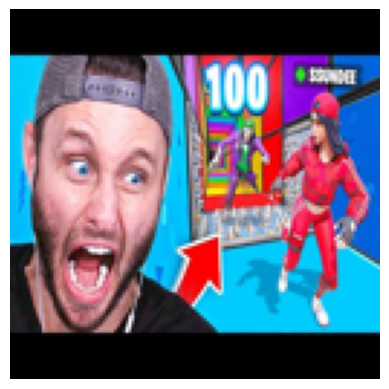

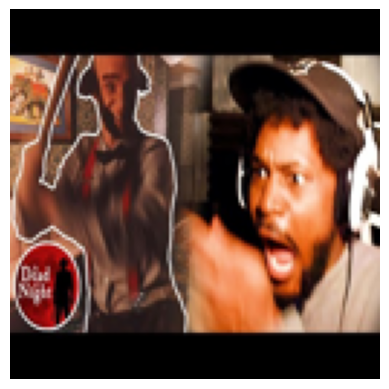

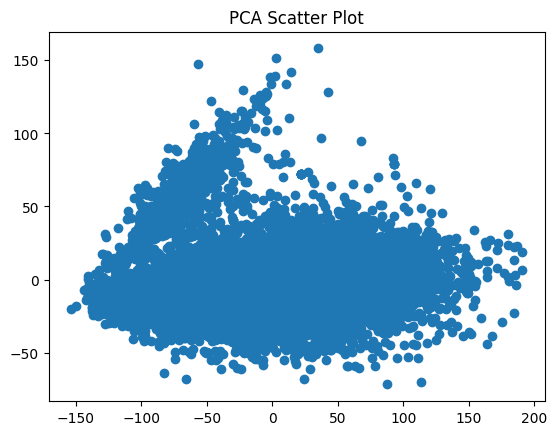

looking up size (128, 128, 3)


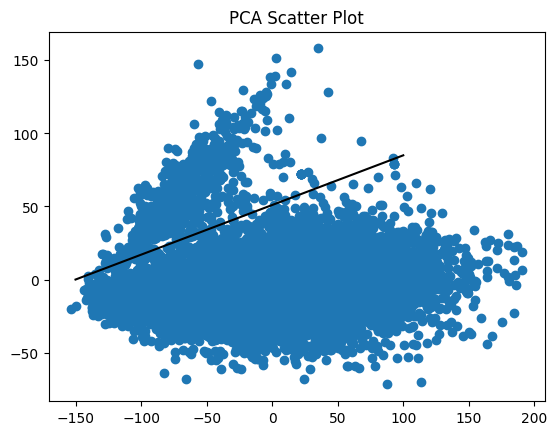

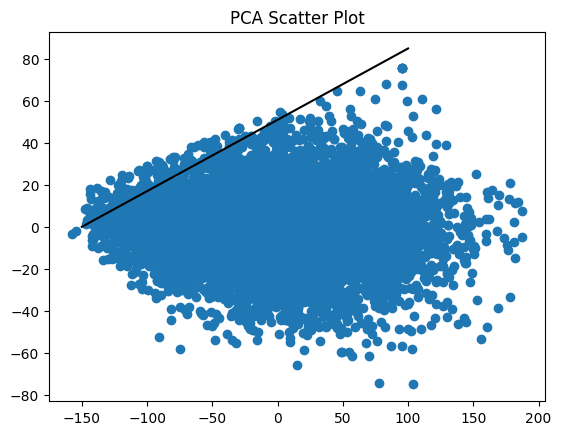

Left with 9783 thumbnails


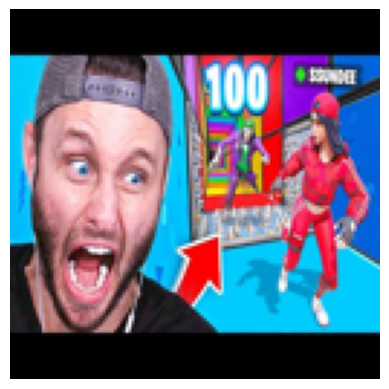

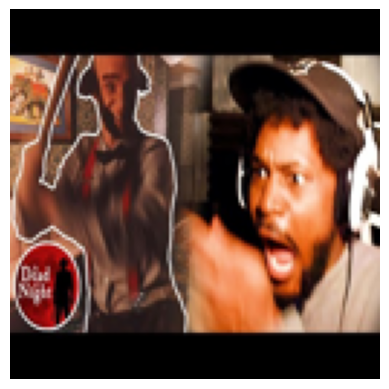

In [12]:
# X_train = get_data(100)
X_train = get_data(img_shape, min_views=500_000)

# Training


In [22]:
# losses = []
# accuracies = []
# iteration_checkpoints = []

# from tqdm import tqdm

# def load_weights(gan):
#     try:
#         gan.load_weights(weight_path)
#         print("Loaded previous weights")
#     except Exception as e:
#         print(e)


# @tf.function
# def train_generator(z):
#     """
#     Need a custom train loop for the generator because I want to factor in generators predictions
#     """
#     with tf.GradientTape() as tape:
#         # Generate fake images using the generator
#         generated_images = generator(z, training=True)
        
#         # Get the discriminator's predictions on the fake images
#         fake_preds = discriminator(generated_images, training=False)

#         # Calculate the loss using the generator's output (generated_images)
#         # and the discriminator's predictions (fake_preds)
#         loss = custom_generator_loss(fake_preds, generated_images)

#     # Calculate the gradients of the loss with respect to the generator's weights
#     grads = tape.gradient(loss, generator.trainable_weights)

#     # Update the weights of the generator
#     generator_optimizer.apply_gradients(zip(grads, generator.trainable_weights))
#     return loss


# def train(iterations, batch_size, sample_interval):


#     # Labels for real images: all ones
#     real = np.ones((batch_size, 1))

#     # Labels for fake images: all zeros
#     fake = np.zeros((batch_size, 1))

#     for iteration in tqdm(range(iterations)):

#         # -------------------------
#         #  Train the Discriminator
#         # -------------------------

#         # Get a random batch of real images
#         idx = np.random.randint(0, X_train.shape[0], batch_size)
#         imgs = X_train[idx]

#         # Generate a batch of fake images
#         z = np.random.normal(0, 1, (batch_size, latent_dim))
#         gen_imgs = generator.predict(z, verbose=0)

#         # Train Discriminator
#         d_loss_real = discriminator.train_on_batch(imgs, real)
#         d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
#         d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

#         # ---------------------
#         #  Train the Generator
#         # ---------------------

#         # Generate a batch of fake images
#         z = np.random.normal(0, 1, (batch_size, latent_dim))
#         gen_imgs = generator.predict(z, verbose=0)

#         # Train Generator
#         # g_loss = gan.train_on_batch(z, real)
#         g_loss = train_generator(z)

#         if (iteration + 1) % sample_interval == 0 or iteration == 0:

#             # Save losses and accuracies so they can be plotted after training
#             losses.append((d_loss, g_loss))
#             accuracies.append(100.0 * accuracy)
#             iteration_checkpoints.append(iteration + 1)

#             # Output training progress
#             print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
#                   (iteration + 1, d_loss, 100.0 * accuracy, g_loss))

#             # Output a sample of generated image
#             # sample_images(generator)
#             gan.save_weights(weight_path)
#             file_name = get_current_time()
#             show_samples(generator, latent_dim, file_name=file_name)
#             show_loss_plot(losses, iteration_checkpoints, file_name=file_name)
#             show_accuracy_plot(accuracies, iteration_checkpoints, file_name=file_name)

In [23]:

# load_weights(gan)
# train(iterations, batch_size, sample_interval)


Loaded previous weights


In [ ]:
show_loss_plot(losses, iteration_checkpoints)

In [ ]:
show_accuracy_plot(accuracies, iteration_checkpoints)

In [ ]:
show_samples(generator, latent_dim, rows=3)

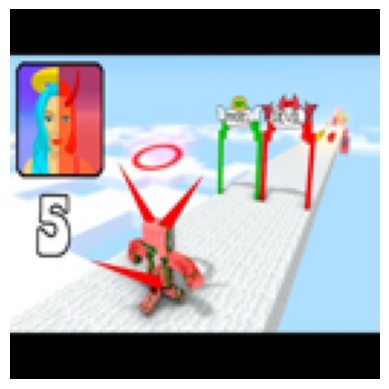

In [18]:

idx = np.random.randint(0, X_train.shape[0], batch_size)
imgs = X_train[idx]
# similarity_penalty_loss( worst_cosine_similarity(imgs))
visualize_preprocessed_image(imgs[0])
# visualize_preprocessed_image(imgs[1])

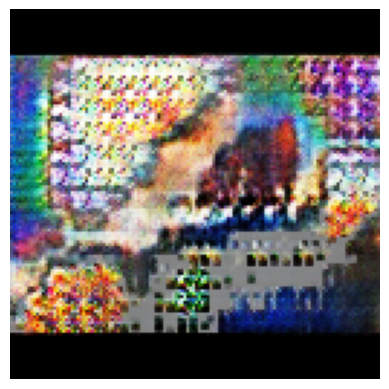

In [24]:

z = np.random.normal(0, 1, (batch_size, latent_dim))
gen_imgs = generator.predict(z, verbose=0)
# gen_imgs 

# similarity_penalty_loss(worst_cosine_similarity(imgs[:8]))
visualize_preprocessed_image(gen_imgs[0])